In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns 

# import test metrics

In [311]:
# import LCE and XGB test metrics
lce = pd.read_csv('/workspace/data/SGU/SFSI/SFSI/LCE10x_akermark_7class/20231122170432/LCE_test_metrics.csv', sep= ',', decimal = '.')
xgb = pd.read_csv('/workspace/data/SGU/SFSI/SFSI/XBG10x_akermark_7class/20231124031245/XGB_test_metrics.csv', sep= ',', decimal = '.')
# read MCC
lce_mcc = lce["MCC (Test)"].to_numpy()
xgb_mcc = xgb["MCC (Test)"].to_numpy()
x = np.column_stack((lce_mcc, xgb_mcc))
x.ndim, x

(2,
 array([[0.71182142, 0.71188885],
        [0.71299783, 0.70950991],
        [0.71257445, 0.70657186],
        [0.71409189, 0.7088547 ],
        [0.72356224, 0.72362122],
        [0.72170051, 0.71650833],
        [0.72700378, 0.71704222],
        [0.72454645, 0.71404505],
        [0.71771537, 0.71343921],
        [0.71724696, 0.7127398 ],
        [0.71278341, 0.70900955],
        [0.72725985, 0.71695441],
        [0.71668862, 0.71483536],
        [0.71870694, 0.71841023],
        [0.7191494 , 0.7156219 ],
        [0.71341259, 0.71033406],
        [0.71814117, 0.71134507],
        [0.7238947 , 0.71380559],
        [0.72147982, 0.72211561],
        [0.72270147, 0.72012118],
        [0.72049109, 0.71996675],
        [0.71305882, 0.71364589],
        [0.72425276, 0.71852433],
        [0.71345482, 0.71006721],
        [0.70842908, 0.71081705],
        [0.7166842 , 0.71631865],
        [0.71537597, 0.71714245],
        [0.71155861, 0.71011982],
        [0.70486191, 0.69904358],
        [0

# plot distribution

LCE mean:  0.7168998615928873


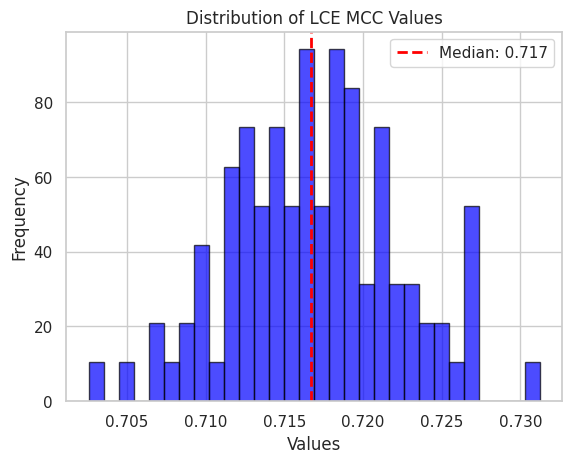

In [312]:
plt.hist(lce_mcc, bins=30, density=True, alpha=0.7, color='blue', edgecolor='black')
# Adding labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
# Display median value
median_value = np.median(lce_mcc)
plt.axvline(median_value, color='red', linestyle='dashed', linewidth=2, label=f'Median: {median_value:.3f}')
plt.title('Distribution of LCE MCC Values')
plt.legend()

print('LCE mean: ', lce_mcc.mean())

0.7134758246154269

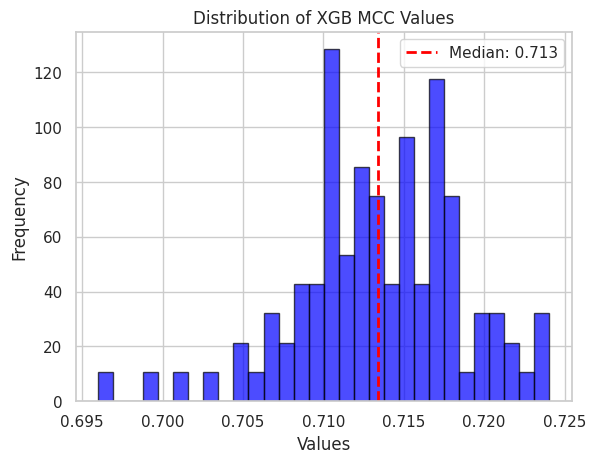

In [313]:
plt.hist(xgb_mcc, bins=30, density=True, alpha=0.7, color='blue', edgecolor='black')
# Display median value
median_value = np.median(xgb_mcc)
plt.axvline(median_value, color='red', linestyle='dashed', linewidth=2, label=f'Median: {median_value:.3f}')
plt.title('Distribution of LCE MCC Values')
# Adding labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of XGB MCC Values')
xgb_mcc.mean()

# defines runs instead of rho

In [283]:
def correlated_ttest(x, rope, runs=1, verbose=False, names=('C1', 'C2')):
    import scipy.stats as stats
    """
    Compute correlated t-test
 
    The function uses the Bayesian interpretation of the p-value and returns
    the probabilities the difference are below `-rope`, within `[-rope, rope]`
    and above the `rope`. For details, see `A Bayesian approach for comparing
    cross-validated algorithms on multiple data sets
    <http://link.springer.com/article/10.1007%2Fs10994-015-5486-z>`_,
    G. Corani and A. Benavoli, Mach Learning 2015.
 
    |
    The test assumes that the classifiers were evaluated using cross
    validation. The number of folds is determined from the length of the vector
    of differences, as `len(diff) / runs`. The variance includes a correction
    for underestimation of variance due to overlapping training sets, as
    described in `Inference for the Generalization Error
    <http://link.springer.com/article/10.1023%2FA%3A1024068626366>`_,
    C. Nadeau and Y. Bengio, Mach Learning 2003.)
 
    |
    Args:
    x (array): a vector of differences or a 2d array with pairs of scores.
    rope (float): the width of the rope  
    runs (int): number of repetitions of cross validation (default: 1)
    return: probablities (tuple) that differences are below -rope, within rope or
        above rope
    """
    if x.ndim == 2:
        x = x[:, 1] - x[:, 0]
    diff=x
    n = len(diff)
    nfolds = n / runs
    x = np.mean(diff)
    # Nadeau's and Bengio's corrected variance
    var = np.var(diff, ddof=1) * (1 / n + 1 / (nfolds - 1))
    if var == 0:
        return int(x < rope), int(-rope <= x <= rope), int(rope < x)
    pr = 1-stats.t.cdf(rope, n - 1, x, np.sqrt(var))
    pl = stats.t.cdf(-rope, n - 1, x, np.sqrt(var))
    pe=1-pl-pr
    if verbose:
        print('P({c1} > {c2}) = {pl}, P(rope) = {pe}, P({c2} > {c1}) = {pr}'.
              format(c1=names[0], c2=names[1], pl=pl, pe=pe, pr=pr))
    return pl, pe, pr

# define rho instead. rho is the ratio between test set and whole dataset

In [319]:
def correlated_ttest(x, rope, rho, verbose=False, names=('C1', 'C2')):
    import scipy.stats as stats
    """
    Compute correlated t-test

    The function uses the Bayesian interpretation of the p-value and returns
    the probabilities the difference are below `-rope`, within `[-rope, rope]`
    and above the `rope`. For details, see `A Bayesian approach for comparing
    cross-validated algorithms on multiple data sets
    <http://link.springer.com/article/10.1007%2Fs10994-015-5486-z>`_,
    G. Corani and A. Benavoli, Mach Learning 2015.

    |
    The test assumes that the classifiers were evaluated using cross
    validation. The number of folds is determined from the length of the vector
    of differences, as `len(diff) / (1 / (1 - rho))`. The variance includes a correction
    for underestimation of variance due to overlapping training sets, as
    described in `Inference for the Generalization Error
    <http://link.springer.com/article/10.1023%2FA%3A1024068626366>`_,
    C. Nadeau and Y. Bengio, Mach Learning 2003.)

    |
    Args:
    x (array): a vector of differences or a 2d array with pairs of scores.
    rope (float): the width of the rope  
    rho (float): the ratio between the test set size and the whole dataset size
    return: probabilities (tuple) that differences are below -rope, within rope or
        above rope
    """
    if x.ndim == 2:
        x = x[:, 1] - x[:, 0]
    diff = x
    n = len(diff)
    correction_factor = (1 / n) + rho / (1 - rho)
    x = np.mean(diff)
    # Nadeau's and Bengio's corrected variance
    var = np.var(diff, ddof=1) * correction_factor
    if var == 0:
        return int(x < rope), int(-rope <= x <= rope), int(rope < x)
    pr = 1 - stats.t.cdf(rope, n - 1, x, np.sqrt(var))
    pl = stats.t.cdf(-rope, n - 1, x, np.sqrt(var))
    pe = 1 - pl - pr
    if verbose:
        print('P({c1} > {c2}) = {pl}, P(rope) = {pe}, P({c2} > {c1}) = {pr}'.
              format(c1=names[0], c2=names[1], pl=pl, pe=pe, pr=pr))
    return pl, pe, pr


In [321]:
names = ['LCE', 'XGB']
rope=0.01
rho=0.11820452940857003
left, within, right = correlated_ttest(x, rope=rope,rho=rho,verbose=True,names=names)

P(LCE > XGB) = 3.538806019883673e-05, P(rope) = 0.9999646119396837, P(XGB > LCE) = 1.1746159600534156e-13


# plot

In [317]:
def correlated_ttest_MC(x, rope, rho,  nsamples=50000):
    """
    See correlated_ttest module for explanations
    """
    if x.ndim == 2:
        x = x[:, 1] - x[:, 0]
    diff=x
    n = len(diff)
    correction_factor = (1 / n) + rho / (1 - rho)
    x = np.mean(diff)
    # Nadeau's and Bengio's corrected variance
    var = np.var(diff, ddof=1) * correction_factor
    if var == 0:
        return int(x < rope), int(-rope <= x <= rope), int(rope < x)
    
    return x+np.sqrt(var)*np.random.standard_t( n - 1, nsamples)

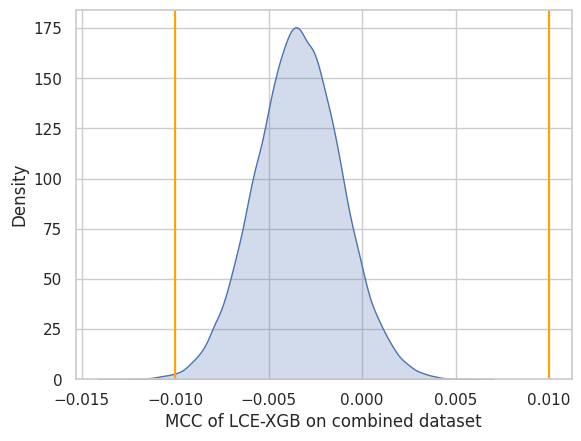

In [322]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as snb
#generate samples from posterior (it is not necesssary because the posterior is a Student)
rope=0.01
rho=0.223
samples=correlated_ttest_MC(x, rope=rope,rho=rho,nsamples=50000)
#plot posterior
snb.kdeplot(samples, shade=True) 
#plot rope region
plt.axvline(x=-rope,color='orange')
plt.axvline(x=rope,color='orange')
#add label
plt.xlabel('MCC of LCE-XGB on combined dataset');

In [288]:
lce.columns

Index(['Test Accuracy', 'Cohen's Kappa (Test)', 'F1 Score (Test) weighted',
       'MCC (Test)', 'F1_unweighted - coarse sed ARG',
       'F1_unweighted - coarse sed Forest', 'F1_unweighted - fine sed Forest',
       'F1_unweighted - fine sed ARG', 'F1_unweighted - peat',
       'F1_unweighted - rock', 'F1_unweighted - till'],
      dtype='object')

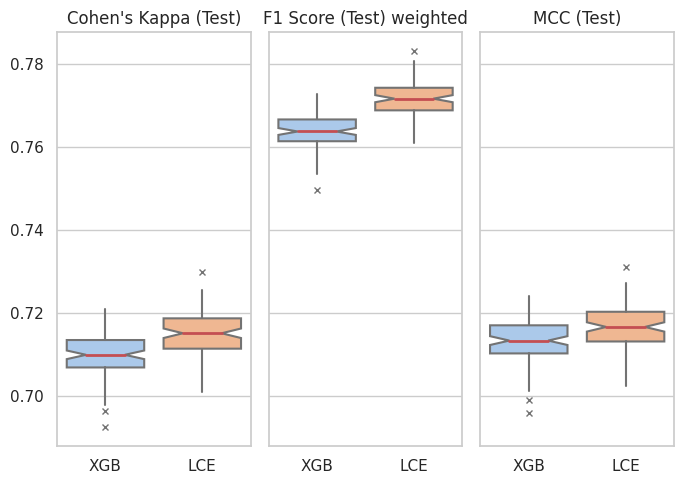

In [323]:

# Columns to plot
columns_to_plot = ["Cohen's Kappa (Test)", 'F1 Score (Test) weighted', 'MCC (Test)']
palette = sns.color_palette("pastel")  # You can choose a different palette

# Number of subplots
num_subplots = len(columns_to_plot)

# Create subplots with shared y-axis
fig, axs = plt.subplots(1, num_subplots, figsize=(7, 5), sharey=True)

# Plot each column side by side using Seaborn boxplot
for i, column in enumerate(columns_to_plot):
    sns.boxplot(data=[xgb[column], lce[column]], ax=axs[i], palette=palette,notch=True, showcaps=False,
    flierprops={"marker": "x"},
    medianprops={"color": "r", "linewidth": 2},)
    axs[i].set_title(column)
    axs[i].set_xticklabels(['XGB', 'LCE'])

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

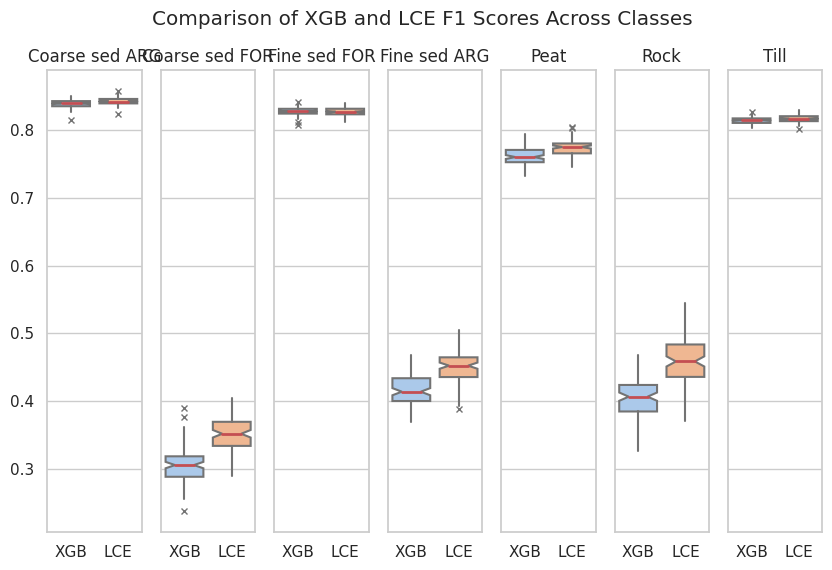

In [324]:
import seaborn as sns

# Columns to plot (assuming your DataFrames are named xgb and lce)
columns_to_plot = xgb.columns[-7:]

# Set Seaborn style and color palette

palette = sns.color_palette("pastel")  # You can choose a different palette
# Class names for each category
class_names = ['Coarse sed ARG', 'Coarse sed FOR', 'Fine sed FOR', 'Fine sed ARG', 'Peat', 'Rock', 'Till']

# Number of subplots
num_subplots = len(columns_to_plot)

# Create subplots with shared y-axis
fig, axs = plt.subplots(1, num_subplots, figsize=(10, 6), sharey=True)

# Plot each column side by side using Seaborn boxplot
for i, column in enumerate(columns_to_plot):
    sns.boxplot(data=[xgb[column], lce[column]], ax=axs[i], palette=palette, notch=True, showcaps=False,
    flierprops={"marker": "x"},
    medianprops={"color": "r", "linewidth": 2},)
    axs[i].set_title(class_names[i])  # Set title based on class_names
    axs[i].set_xticklabels(['XGB', 'LCE']) 

# Set a main title
fig.suptitle('Comparison of XGB and LCE F1 Scores Across Classes')

# Adjust layout
plt.tight_layout(rect=[0, 1.03, 1, 0.95]) 
# Show the plot
plt.show()
